In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
import pysam
import os

def Find_patient_information(patient_ID):
    patient_information = ["patient_ID","patient_type","IBD","day","month","year","seqID_virome"] 
    data_frame = pd.read_csv("PHAGE_BUBBLE/Freeze3_metadata.csv", header=0,
                             dtype=str, na_values=['NA'],
                             skip_blank_lines=True,
                             true_values=['true'], false_values=['false'],
                             nrows=None)

    
    patient_ID_whole_metadata = data_frame[data_frame["patient_ID"] == patient_ID] # Select all the row with the patient_ID
    selected_data = patient_ID_whole_metadata[patient_information] # select all the column within this list
    selected_data = selected_data.dropna(subset=["seqID_virome"]) # Remove all rows with 'NaN' in the SeqID column 
    return selected_data

def condense_data_file_and_time(data):
    Time_dict = {'Time': [f"{day}-{month}-{year}" for day, month, year in zip(data['day'], data['month'], data['year'])]}
    File_name_dict = {'File_name': [f"{seqID_virome}" for seqID_virome in data['seqID_virome']]}
    Time_dict.update(File_name_dict)
    return Time_dict
    
def write_output_for_Bash_command(data, patient_ID): # take data from the condense_data_file_and_time Function
    output_file_path = f'Time_series/Sample_output/{patient_ID}_sample_output.txt'
    with open(output_file_path, 'w') as file:
        for item in data["seqID_virome"]:
            if not pd.isna(item):
                file.write("%s\n" % item)
    
def Find_bamfiles(folder_path, FILE_ID):       
    file_list = [
        os.path.join(folder_path, filename)
        for filename in os.listdir(folder_path)
        if filename.startswith(tuple(FILE_ID)) and filename.endswith(".bam")
    ]
    return file_list

def Find_Library_Size(Library_size_matrix):
    data_frame = pd.read_csv(Library_size_matrix, sep='\t')
    Identification = data_frame.iloc[:,0]
                
    size_dict = {}
    for id_value in Identification:
        try:
            Library_Size = data_frame.loc[data_frame['Sample_name'] == id_value, 'Libary_Size'].values[0]
            size_dict[id_value] = Library_Size
        except IndexError:
            print(f"ID '{id_value}' not found in the table.")
            return None
    return size_dict

def Find_contigs(filepaths):
    contigs = []
    for record in SeqIO.parse(filepaths, "fasta"):
        contigs.append(record.id) 
    return contigs

def Find_relative_abundance(component, Patient_ID, File_Time_dict):   
    File_name = File_Time_dict["File_name"]
    Dict_Sample_ID = Find_Library_Size("PHAGE_BUBBLE/sampleSeqCounts.tsv") # METAdata file, cannot change
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta") # Component file location, fixed.
    File_name_lists = Find_bamfiles(f"Time_series/Patient_sample/{Patient_ID}/{component}", File_name) # location of bamfiles sorted, fixed.
    
    dict_data = {}
    for ID in File_name:
        bam_files = [file_path for file_path in File_name_lists if file_path.startswith(f"Time_series/Patient_sample/{Patient_ID}")]
        if ID not in dict_data:
            dict_data[ID] = {}
        for bam_file in bam_files:
            if ID in bam_file:
                # print(bam_file)
                with pysam.AlignmentFile(bam_file, 'rb') as bamfile:               
                    for references in bamfile.references:
                        mapped_reads = bamfile.count(reference=references,
                                                     read_callback=lambda read: not read.is_unmapped) 
                        genome_length = bamfile.get_reference_length(references)
                        for id_value, library_size in Dict_Sample_ID.items():
                            if id_value in bam_file:
                                Library_Size = library_size  
                            # print(f"{references}: mapped read = {mapped_reads}")
                            # print(f"Genome length = {genome_length}")
                        Rel_Ab = (mapped_reads * (1000000))/(Library_Size * genome_length)
                        # print(f"{ID}:{references}: Library_size = {Library_Size}: mapped read = {mapped_reads}: Rel_Ab = {Rel_Ab}")     
                        dict_data[ID][references] = Rel_Ab # Append the Relative abundance into the correct ID dictiondary in a list.
    return dict_data

In [5]:
def print_abundance_determination_scratch(component, Patient_ID):
    Dict_1 = condense_data_file_and_time(Find_patient_information(Patient_ID)) # Dict_1 has patient's info skimmed down, it has Filename and Time.
    Dict_2 = Find_relative_abundance_scratch(component, Patient_ID, Dict_1)
    # print(Dict_2)
                # Dict_2 takes dict_1 info and create a dictionary with filename to paths to abundance.

    # Create an array for each paths which contain abundance calculation
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta")
    Paths_RAb = {}       

    Mean_list = {}
    for contig in contigs: 
        value = [Dict_2[y][contig] for y in Dict_2.keys()]
        Paths_RAb[contig] = value    
        mean_number = np.mean(value)
        Mean_list[contig] = mean_number
        # print(f"The mean of {contig} = {mean_number}") 
    max_key = max(Mean_list, key=lambda k: Mean_list[k])
    max_value = Mean_list[max_key]
    
    List_of_means_from_dict = [value for key, value in Mean_list.items()]
    Mean_of_mean = sum(List_of_means_from_dict) / len(List_of_means_from_dict)
    ### Abundance Determination: 
    Paths_RAb = pd.DataFrame(Paths_RAb)
    Paths_RAb_data = {'Frequency' : {},'Dominance_value' : {}}
    for contig in contigs: 
        count = Paths_RAb[contig].eq(0).sum()
        abundance = (100 - (count /  len(Paths_RAb)) * 100)
        Paths_RAb_data['Frequency'][contig] = abundance
        
        for key, mean_number in Mean_list.items():
            if key == contig:
                if max_value != 0:
                    mean_score = (mean_number / max_value)
                else:
                    mean_score = 0
                Paths_RAb_data['Dominance_value'][contig] = mean_score
    # print(Paths_RAb_data)
    
    
    del Mean_list[max_key]

    # Now, get the maximum value again, which will be the second maximum
    second_max_key = max(Mean_list, key=lambda k: Mean_list[k])
    second_max_value = Mean_list[second_max_key]
    
    
    ### Domination Determination:
    sum_value = 0
    for contig, value in Paths_RAb_data['Frequency'].items():
        # print(value)
        sum_value += value
    # print(sum_value)
    average = sum_value / len(Paths_RAb_data['Frequency'])
    # print(average)
    if average == 0:
        category_frequency = 'No Abundance'
    elif average > 80:
        category_frequency = 'Consistent'
    elif average < 20:
        category_frequency = 'Low_consistent'
    else: 
        category_frequency = 'Somewhat_consistent'
    
    # print(f"{max_value} {second_max_value}")
    if max_value != 0: 
        ratio = (second_max_value / max_value)
        if ratio > 0.2:
            if ratio < 0.8: 
                categories = 'Dominance'
            else:
                categories = 'Co-dominance' 
        else: 
            categories = 'Dominance'
    else: 
        categories = "No Abundance"
    Categories_dict = {}
    for components, classification in Annotation_dict.items():
        if components == component: 
            Class = classification
    if categories != "No Abundance" and category_frequency != 'Low_consistent':
        # print('Removed categories')
        Categories_dict = {'Patient' : Patient_ID, 'Component' : component , 'Classification' : Class,'category_frequency' : category_frequency, 
                           'categories_dominance' : categories, 'Both' : f'{category_frequency}_{categories}', 'Mean' : Mean_of_mean}
    return Categories_dict

In [6]:
def Find_relative_abundance_scratch(component, Patient_ID, File_Time_dict):   
    File_name = File_Time_dict["File_name"]
    Dict_Sample_ID = Find_Library_Size("PHAGE_BUBBLE/sampleSeqCounts.tsv") # METAdata file, cannot change
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta") # Component file location, fixed.
    File_name_lists = Find_bamfiles(f"/scratch/user/pham0323/Time_series/Patient_sample/{Patient_ID}/{component}", File_name) # location of bamfiles sorted, fixed.
    
    
    dict_data = {}
    for ID in File_name:
        if ID is not 'M513_I6688_14946_Parkes_IBD_203_1_NEBNextIndex29_CAACTAATCT_S7_L001':
            bam_files = [file_path for file_path in File_name_lists if file_path.startswith(f"/scratch/user/pham0323/Time_series/Patient_sample/{Patient_ID}")]
        if ID not in dict_data:
            dict_data[ID] = {}
        for bam_file in bam_files:
            if ID in bam_file:
                # print(bam_file)
                with pysam.AlignmentFile(bam_file, 'rb') as bamfile:               
                    for references in bamfile.references:
                        mapped_reads = bamfile.count(reference=references,
                                                     read_callback=lambda read: not read.is_unmapped) 
                        genome_length = bamfile.get_reference_length(references)
                        for id_value, library_size in Dict_Sample_ID.items():
                            if id_value in bam_file:
                                Library_Size = library_size  
                            # print(f"{references}: mapped read = {mapped_reads}")
                            # print(f"Genome length = {genome_length}")
                        Rel_Ab = (mapped_reads * (1000000))/(Library_Size * genome_length)
                        # print(f"{ID}:{references}: Library_size = {Library_Size}: mapped read = {mapped_reads}: Rel_Ab = {Rel_Ab}")     
                        dict_data[ID][references] = Rel_Ab # Append the Relative abundance into the correct ID dictiondary in a list.
    return dict_data

def print_abundance_determination(component, Patient_ID):
    Dict_1 = condense_data_file_and_time(Find_patient_information(Patient_ID)) # Dict_1 has patient's info skimmed down, it has Filename and Time.
    Dict_2 = Find_relative_abundance(component, Patient_ID, Dict_1)
    # Dict_3 = Find_relative_abundance_scratch(component, Patient_ID, Dict_1)
    # Dict_2.update(Dict_3)
    # print(Dict_2)
                # Dict_2 takes dict_1 info and create a dictionary with filename to paths to abundance.

    # Create an array for each paths which contain abundance calculation
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta")
    Paths_RAb = {}       

    Mean_list = {}
    for contig in contigs: 
        value = [Dict_2[y][contig] for y in Dict_2.keys()]
        Paths_RAb[contig] = value    
        mean_number = np.mean(value)
        Mean_list[contig] = mean_number
        # print(f"The mean of {contig} = {mean_number}") 
    max_key = max(Mean_list, key=lambda k: Mean_list[k])
    max_value = Mean_list[max_key]
    
    List_of_means_from_dict = [value for key, value in Mean_list.items()]
    Mean_of_mean = sum(List_of_means_from_dict) / len(List_of_means_from_dict)
    ### Abundance Determination: 
    Paths_RAb = pd.DataFrame(Paths_RAb)
    Paths_RAb_data = {'Frequency' : {},'Dominance_value' : {}}
    for contig in contigs: 
        count = Paths_RAb[contig].eq(0).sum()
        abundance = (100 - (count /  len(Paths_RAb)) * 100)
        Paths_RAb_data['Frequency'][contig] = abundance
        
        for key, mean_number in Mean_list.items():
            if key == contig:
                if max_value != 0:
                    mean_score = (mean_number / max_value)
                else:
                    mean_score = 0
                Paths_RAb_data['Dominance_value'][contig] = mean_score
    print(Paths_RAb_data)
    
    
    del Mean_list[max_key]

    # Now, get the maximum value again, which will be the second maximum
    second_max_key = max(Mean_list, key=lambda k: Mean_list[k])
    second_max_value = Mean_list[second_max_key]
    
    
    ### Domination Determination:
    sum_value = 0
    for contig, value in Paths_RAb_data['Frequency'].items():
        # print(value)
        sum_value += value
    # print(sum_value)
    average = sum_value / len(Paths_RAb_data['Frequency'])
    # print(average)
    if average == 0:
        category_frequency = 'No Abundance'
    elif average > 80:
        category_frequency = 'Consistent'
    elif average < 20:
        category_frequency = 'Low_consistent'
    else: 
        category_frequency = 'Somewhat_consistent'
    
    # print(f"{max_value} {second_max_value}")
    if max_value != 0: 
        ratio = (second_max_value / max_value)
        if ratio > 0.2:
            if ratio < 0.8: 
                categories = 'Dominance'
            else:
                categories = 'Co-dominance' 
        else: 
            categories = 'Dominance'
    else: 
        categories = "No Abundance"
    Categories_dict = {}
    for components, classification in Annotation_dict.items():
        if components == component: 
            Class = classification
    if categories != "No Abundance" and category_frequency != 'Low_consistent':
        # print('Removed categories')
        Categories_dict = {'Patient' : Patient_ID, 'Component' : component , 'Classification' : Class,'category_frequency' : category_frequency, 
                           'categories_dominance' : categories, 'Both' : f'{category_frequency}_{categories}', 'Mean' : Mean_of_mean}
    return Categories_dict
    # print(Paths_RAb_data)
    ## Evaluating the variance Abundance Type
    ## IF Abundance < 20%, then it is Opportunistic
    ## IF Abundance > 80%, then it is Consistent Abundant
    ## IF anything else, then it is Somewhat Abundant
# print_abundance_determination('phage_comp_10', '1012A')
print_abundance_determination('phage_comp_21', '1012A')

{'Frequency': {'phage_comp_21_cycle_1': 46.666666666666664, 'phage_comp_21_cycle_4': 40.0, 'phage_comp_21_cycle_5': 46.666666666666664}, 'Dominance_value': {'phage_comp_21_cycle_1': 0.80856012522418, 'phage_comp_21_cycle_4': 0.6302923957201936, 'phage_comp_21_cycle_5': 1.0}}


NameError: name 'Annotation_dict' is not defined

In [33]:
def Find_relative_abundance_scratch(component, Patient_ID, File_Time_dict):   
    File_name = File_Time_dict["File_name"]
    Dict_Sample_ID = Find_Library_Size("PHAGE_BUBBLE/sampleSeqCounts.tsv") # METAdata file, cannot change
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta") # Component file location, fixed.
    File_name_lists = Find_bamfiles(f"/scratch/user/pham0323/Time_series/Patient_sample/{Patient_ID}/{component}", File_name) # location of bamfiles sorted, fixed.
    
    
    dict_data = {}
    for ID in File_name:
        if ID is not 'M513_I6688_14946_Parkes_IBD_203_1_NEBNextIndex29_CAACTAATCT_S7_L001':
            bam_files = [file_path for file_path in File_name_lists if file_path.startswith(f"/scratch/user/pham0323/Time_series/Patient_sample/{Patient_ID}")]
        if ID not in dict_data:
            dict_data[ID] = {}
        for bam_file in bam_files:
            if ID in bam_file:
                # print(bam_file)
                with pysam.AlignmentFile(bam_file, 'rb') as bamfile:               
                    for references in bamfile.references:
                        mapped_reads = bamfile.count(reference=references,
                                                     read_callback=lambda read: not read.is_unmapped) 
                        genome_length = bamfile.get_reference_length(references)
                        for id_value, library_size in Dict_Sample_ID.items():
                            if id_value in bam_file:
                                Library_Size = library_size  
                            # print(f"{references}: mapped read = {mapped_reads}")
                            # print(f"Genome length = {genome_length}")
                        Rel_Ab = (mapped_reads * (1000000))/(Library_Size * genome_length)
                        # print(f"{ID}:{references}: Library_size = {Library_Size}: mapped read = {mapped_reads}: Rel_Ab = {Rel_Ab}")     
                        dict_data[ID][references] = Rel_Ab # Append the Relative abundance into the correct ID dictiondary in a list.
    return dict_data

def print_abundance_determination_all_abundance(component, Patient_ID):
    Dict_1 = condense_data_file_and_time(Find_patient_information(Patient_ID)) # Dict_1 has patient's info skimmed down, it has Filename and Time.
    Dict_2 = Find_relative_abundance(component, Patient_ID, Dict_1)

    # Create an array for each paths which contain abundance calculation
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta")
    Paths_RAb = {}       

    Mean_list = {}
    for contig in contigs: 
        value = [Dict_2[y][contig] for y in Dict_2.keys()]
        Paths_RAb[contig] = value    
        mean_number = np.mean(value)
        Mean_list[contig] = mean_number
        # print(f"The mean of {contig} = {mean_number}") 
    max_key = max(Mean_list, key=lambda k: Mean_list[k])
    max_value = Mean_list[max_key]
    
    # print(Paths_RAb)
    ### Abundance Determination: 
    Paths_RAb_dataframe = pd.DataFrame(Paths_RAb)
    Paths_RAb_data = {'Frequency' : {},'Dominance_value' : {}}
    for contig in contigs: 
        count = Paths_RAb_dataframe[contig].eq(0).sum()
        abundance = (100 - (count /  len(Paths_RAb_dataframe)) * 100)
        Paths_RAb_data['Frequency'][contig] = abundance
        
        for key, mean_number in Mean_list.items():
            if key == contig:
                if max_value != 0:
                    mean_score = (mean_number / max_value)
                else:
                    mean_score = 0
                Paths_RAb_data['Dominance_value'][contig] = mean_score
    # print(Paths_RAb_data)
    
    
    del Mean_list[max_key]

    # Now, get the maximum value again, which will be the second maximum
    second_max_key = max(Mean_list, key=lambda k: Mean_list[k])
    second_max_value = Mean_list[second_max_key]
    
    
    ### Domination Determination:
    sum_value = 0
    for contig, value in Paths_RAb_data['Frequency'].items():
        # print(value)
        sum_value += value
    # print(sum_value)
    average = sum_value / len(Paths_RAb_data['Frequency'])
    # print(average)
    if average == 0:
        category_frequency = 'No Abundance'
    elif average > 80:
        category_frequency = 'Consistent'
    elif average < 20:
        category_frequency = 'Low_consistent'
    else: 
        category_frequency = 'Somewhat_consistent'
    
    ## Evaluating the variance Abundance Type
    ## IF Abundance < 20%, then it is Opportunistic
    ## IF Abundance > 80%, then it is Consistent Abundant
    ## IF anything else, then it is Somewhat Abundant
    if max_value != 0: 
        ratio = (second_max_value / max_value)
        if ratio > 0.2:
            if ratio < 0.8: 
                categories = 'Dominance'
            else:
                categories = 'Co-dominance' 
        else: 
            categories = 'Dominance'
    else: 
        categories = "No Abundance"
    Categories_dict = {}
    for components, classification in Annotation_dict.items():
        if components == component: 
            Class = classification
    for components, Host_predicted in Host_predict_dict.items():
        number = key.split('_')[1]
        modified_comp = f'{value}_{key}'
        if components == component:
            Host = Host_predicted
            
    if categories != "No Abundance" and category_frequency != 'Low_consistent':
        Categories_dict = {'Patient' : Patient_ID, 'Component' : component ,'Classification' : Class, 'Host' : Host,
                           'category_frequency' : category_frequency, 'categories_dominance' : categories}
        Categories_dict['contigs'] = [contig for contig in Paths_RAb.keys()]
        # Categories_dict['seqID_virome'] = [y for y in Dict_2.keys()]
        Categories_dict['Relative abundance'] = [value for key, value in Paths_RAb.items()]
    return Categories_dict

In [34]:
def print_abundance_determination_all_abundance_scratch(component, Patient_ID):
    Dict_1 = condense_data_file_and_time(Find_patient_information(Patient_ID)) # Dict_1 has patient's info skimmed down, it has Filename and Time.
    Dict_2 = Find_relative_abundance_scratch(component, Patient_ID, Dict_1)
    # print(Dict_2)
                # Dict_2 takes dict_1 info and create a dictionary with filename to paths to abundance.

    # Create an array for each paths which contain abundance calculation
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta")
    Paths_RAb = {}       

    Mean_list = {}
    for contig in contigs: 
        value = [Dict_2[y][contig] for y in Dict_2.keys()]
        Paths_RAb[contig] = value    
        mean_number = np.mean(value)
        Mean_list[contig] = mean_number
        # print(f"The mean of {contig} = {mean_number}") 
    max_key = max(Mean_list, key=lambda k: Mean_list[k])
    max_value = Mean_list[max_key]
    
    # print(Paths_RAb)
    ### Abundance Determination: 
    Paths_RAb_dataframe = pd.DataFrame(Paths_RAb)
    Paths_RAb_data = {'Frequency' : {},'Dominance_value' : {}}
    for contig in contigs: 
        count = Paths_RAb_dataframe[contig].eq(0).sum()
        abundance = (100 - (count /  len(Paths_RAb_dataframe)) * 100)
        Paths_RAb_data['Frequency'][contig] = abundance
        
        for key, mean_number in Mean_list.items():
            if key == contig:
                if max_value != 0:
                    mean_score = (mean_number / max_value)
                else:
                    mean_score = 0
                Paths_RAb_data['Dominance_value'][contig] = mean_score
    # print(Paths_RAb_data)
    
    
    del Mean_list[max_key]

    # Now, get the maximum value again, which will be the second maximum
    second_max_key = max(Mean_list, key=lambda k: Mean_list[k])
    second_max_value = Mean_list[second_max_key]
    
    
    ### Domination Determination:
    sum_value = 0
    for contig, value in Paths_RAb_data['Frequency'].items():
        # print(value)
        sum_value += value
    # print(sum_value)
    average = sum_value / len(Paths_RAb_data['Frequency'])
    # print(average)
    if average == 0:
        category_frequency = 'No Abundance'
    elif average > 80:
        category_frequency = 'Consistent'
    elif average < 20:
        category_frequency = 'Low_consistent'
    else: 
        category_frequency = 'Somewhat_consistent'
    
    # print(f"{max_value} {second_max_value}")
    if max_value != 0: 
        ratio = (second_max_value / max_value)
        if ratio > 0.2:
            if ratio < 0.8: 
                categories = 'Dominance'
            else:
                categories = 'Co-dominance' 
        else: 
            categories = 'Dominance'
    else: 
        categories = "No Abundance"
    Categories_dict = {}
    for components, classification in Annotation_dict.items():
        if components == component: 
            Class = classification
    for components, Host_predicted in Host_predict_dict.items():
        number = key.split('_')[1]
        modified_comp = f'{value}_{key}'
        if components == component:
            Host = Host_predicted
            
    if categories != "No Abundance" and category_frequency != 'Low_consistent':
        Categories_dict = {'Patient' : Patient_ID, 'Component' : component ,'Classification' : Class, 'Host' : Host,
                           'category_frequency' : category_frequency, 'categories_dominance' : categories}
        Categories_dict['contigs'] = [contig for contig in Paths_RAb.keys()]
        # Categories_dict['seqID_virome'] = [y for y in Dict_2.keys()]
        Categories_dict['Relative abundance'] = [value for key, value in Paths_RAb.items()]
    return Categories_dict

In [ ]:
import pandas as pd
patient_ID_list =['230_4','282','1012A','2093A','2028A','2037A']
patient_ID_list_scratch =['2064A','2065A','228','203','2036A','2032A','2056A','2057A','2066A','234','268']

# Component = ['phage_comp_5', 'phage_comp_10', 'phage_comp_21', 'phage_comp_24', 'phage_comp_28',
#              'phage_comp_31', 'phage_comp_73', 'phage_comp_76','phage_comp_87', 'phage_comp_93']
Component = ['phage_comp_5', 'phage_comp_10', 'phage_comp_21', 'phage_comp_24', 'phage_comp_26', 'phage_comp_27', 'phage_comp_28',
             'phage_comp_31', 'phage_comp_45', 'phage_comp_46', 'phage_comp_65', 'phage_comp_73', 'phage_comp_76', 'phage_comp_86',
             'phage_comp_87', 'phage_comp_93', 'phage_comp_105', 'phage_comp_122', 'phage_comp_142']

def Dominance_determine_algorithm(patient):
    for component in Component: 
        print(component)
        print_abundance_determination_all_abundance(component, patient)
        
def Dominance_determine_algorithm_scratch(patient):
    for component in Component: 
        print(component)
        print_abundance_determination_all_abundance_scratch(component, patient)
    
# category_to_remove = ['No Abundance', 'Low_consistent']
All_dict = pd.DataFrame()
for component in Component:
    for patient in patient_ID_list:
        dict_1 = print_abundance_determination_all_abundance(component, patient)
        if dict_1:
            df1 = pd.DataFrame(dict_1)
            df1 = df1.explode('Relative abundance').reset_index(drop=True)
            df1.columns = ['Patient', 'Component','Classification','Host', 'category_frequency','categories_dominance', 'Contigs', 'Relative abundance']
            df1 = df1[df1['Relative abundance'] != 0]
            # print(df1)
            All_dict = All_dict.append(df1, ignore_index=True)

    for patient_scratch in patient_ID_list_scratch:
        dict_2 = print_abundance_determination_all_abundance_scratch(component, patient_scratch)
        if dict_2:
            df2 = pd.DataFrame(dict_2)
            df2 = df2.explode('Relative abundance').reset_index(drop=True)
            df2.columns = ['Patient', 'Component','Classification', 'Host', 'category_frequency','categories_dominance', 'Contigs', 'Relative abundance']
            df2 = df2[df2['Relative abundance'] != 0]
            # print(df2)
            All_dict = All_dict.append(df2, ignore_index=True)
# print(All_dict)
All_dict.to_csv('BIGTABLE_DOMINANCE_DETERMINATION_BestVersion.tsv', sep='\t', index=False) 

In [ ]:
Component = ['phage_comp_5', 'phage_comp_10', 'phage_comp_21', 'phage_comp_24', 'phage_comp_26', 'phage_comp_27', 'phage_comp_28',
 'phage_comp_31', 'phage_comp_45', 'phage_comp_46', 'phage_comp_65', 'phage_comp_73', 'phage_comp_76', 'phage_comp_86',
 'phage_comp_87', 'phage_comp_93', 'phage_comp_105', 'phage_comp_122', 'phage_comp_142']

prophage = "prophage"
temperate_phage = 'temperate'
lytic_phage = 'lytic'
unknown = 'unknown'

Annotation_dict = {'phage_comp_5' : unknown, 'phage_comp_10' : lytic_phage, 'phage_comp_21' : temperate_phage, 'phage_comp_24': temperate_phage, 
                   'phage_comp_26' : lytic_phage, 'phage_comp_27' : temperate_phage, 'phage_comp_28': lytic_phage, 'phage_comp_31' : temperate_phage,
                   'phage_comp_45' : lytic_phage, 'phage_comp_46' : temperate_phage, 'phage_comp_65' : unknown, 'phage_comp_73': lytic_phage, 
                   'phage_comp_76' : unknown, 'phage_comp_86' : lytic_phage,  'phage_comp_87' : temperate_phage, 'phage_comp_93' : temperate_phage, 
                   'phage_comp_105' : unknown, 'phage_comp_122' : temperate_phage, 'phage_comp_142' : lytic_phage}

Host_predict_dict = {'phage_comp_5' : 'unknown', 'phage_comp_10' : 'Bacteroides', 'phage_comp_21' : 'Dorea', 'phage_comp_24': 'Veillonella', 
                   'phage_comp_26' : 'Bacteroides', 'phage_comp_27' : 'Ruminococcus', 'phage_comp_28': 'Bacteroides', 'phage_comp_31' : 'Alistipes',
                   'phage_comp_45' : 'Bacteroides', 'phage_comp_46' : 'Eubacterium', 'phage_comp_65' : 'Clostridium', 'phage_comp_73': 'Prevotella', 
                   'phage_comp_76' : 'Prevotella', 'phage_comp_86' : 'Ruminococcus',  'phage_comp_87' : 'Roseburia', 'phage_comp_93' : 'Roseburia', 
                   'phage_comp_105' : 'Clostridium', 'phage_comp_122' : 'Eubacterium', 'phage_comp_142' : 'Lachnoclostridium'}

high_codominance_component = ['phage_comp_5','phage_comp_21', 'phage_comp_24',  'phage_comp_27', 'phage_comp_28', 'phage_comp_31',  
                               'phage_comp_76','phage_comp_87', 'phage_comp_86','phage_comp_93',  'phage_comp_122']
high_dominance_component = [ 'phage_comp_10', 'phage_comp_26', 'phage_comp_45', 'phage_comp_46','phage_comp_65', 'phage_comp_73', 'phage_comp_86','phage_comp_105', 'phage_comp_142']

lytic_phages = ['phage_comp_10', 'phage_comp_26', 'phage_comp_28', 'phage_comp_45', 'phage_comp_73', 'phage_comp_86','phage_comp_142']
temperate_phages = ['phage_comp_21', 'phage_comp_24',  'phage_comp_27', 'phage_comp_31', 'phage_comp_46', 'phage_comp_87','phage_comp_93',  'phage_comp_122']

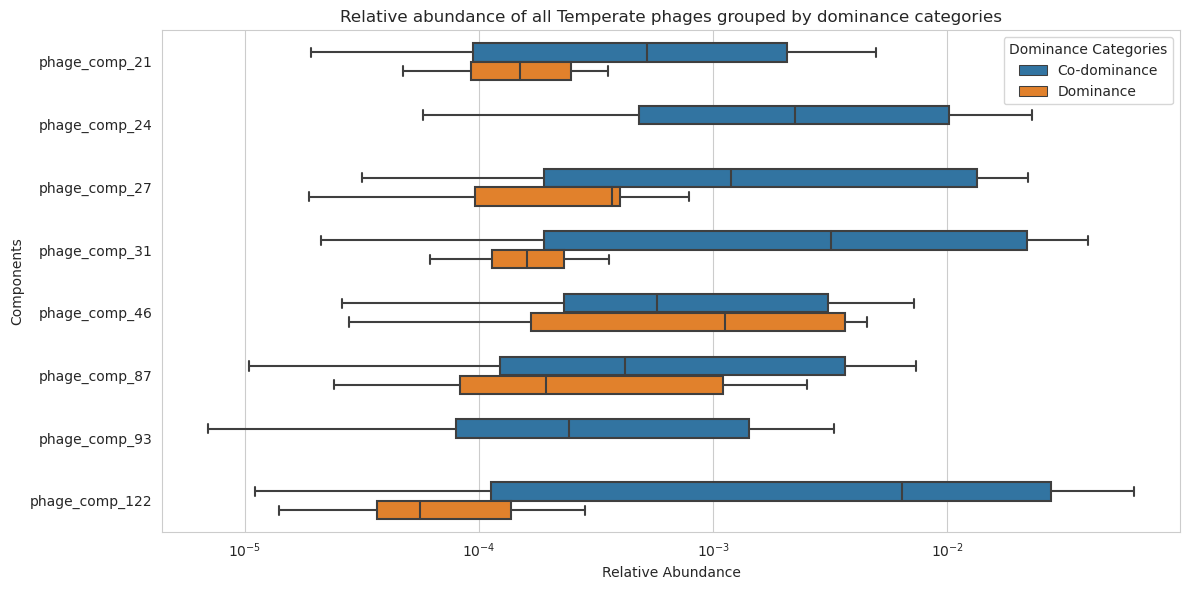

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

data_new = pd.read_csv('BIGTABLE_DOMINANCE_DETERMINATION_BestVersion.tsv', delimiter='\t')
# data_new = data_new[data_new['Component'].isin(lytic_phages)]
data_new = data_new[data_new['Component'].isin(temperate_phages)]
# Create a boxplot using Seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(12,6))
# Set the X-axis to logarithmic scale
plt.xscale('log')

# Ploting the data distribution using boxplot: 
hue_order = ['Co-dominance', 'Dominance']
sns.boxplot(x='Relative abundance', y='Component', hue='categories_dominance', data=data_new, width=0.6, showfliers=False, hue_order=hue_order, orient='h')

plt.ylabel('Components')
plt.xlabel('Relative Abundance')

plt.title('Relative abundance of all Temperate phages grouped by dominance categories')
plt.savefig('Temperate_phages_Categories.png', dpi=300, bbox_inches='tight', format="png")

plt.legend(title='Dominance Categories', loc='upper right')  # Add a legend
plt.tight_layout()
plt.show()

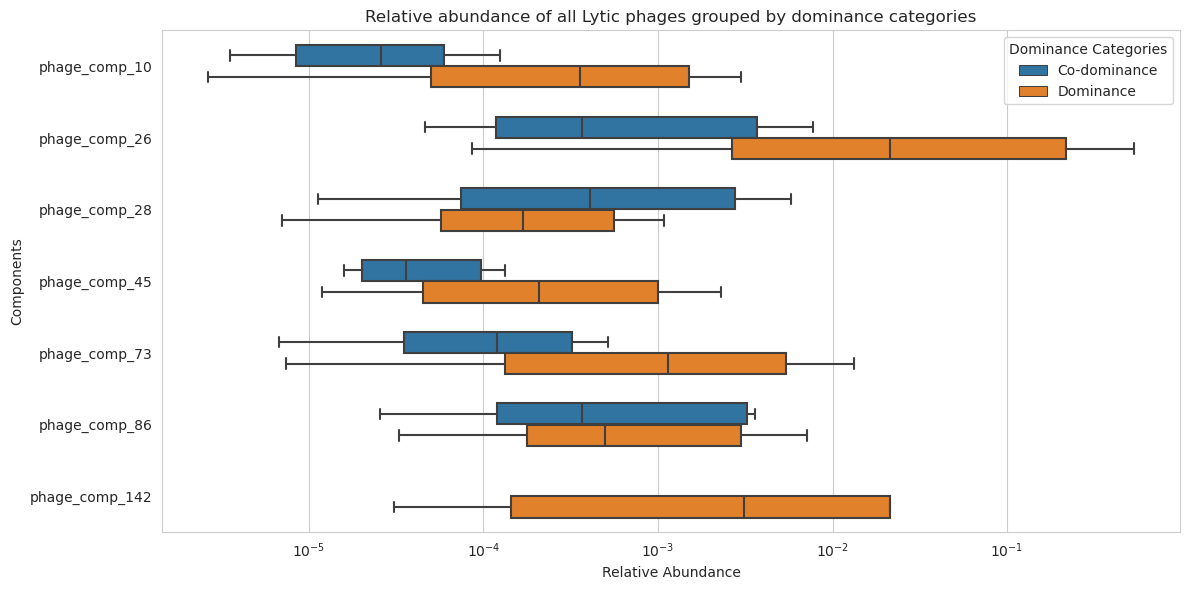

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

data_new = pd.read_csv('BIGTABLE_DOMINANCE_DETERMINATION_BestVersion.tsv', delimiter='\t')
data_new = data_new[data_new['Component'].isin(lytic_phages)]
# Create a boxplot using Seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(12,6))
# Set the X-axis to logarithmic scale
plt.xscale('log')

# Ploting the data distribution using boxplot: 
hue_order = ['Co-dominance', 'Dominance']
sns.boxplot(x='Relative abundance', y='Component', hue='categories_dominance', data=data_new, width=0.6, showfliers=False, hue_order=hue_order, orient='h')

plt.ylabel('Components')
plt.xlabel('Relative Abundance')

plt.title('Relative abundance of all Lytic phages grouped by dominance categories')
plt.savefig('Lytic_phages_Categories.png', dpi=300, bbox_inches='tight', format="png")

plt.legend(title='Dominance Categories', loc='upper right')  # Add a legend
plt.tight_layout()
plt.show()

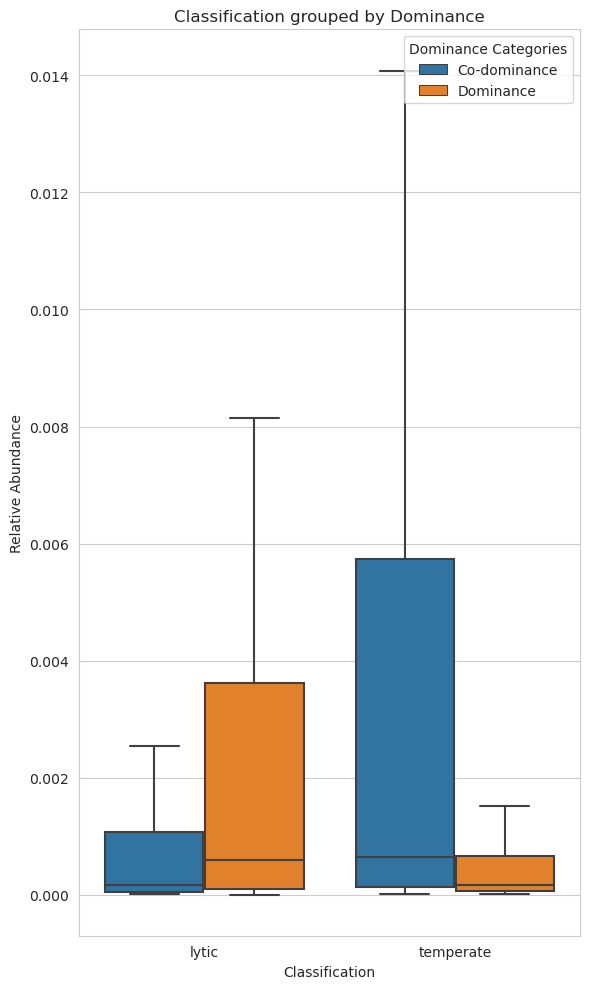

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

data_new = pd.read_csv('BIGTABLE_DOMINANCE_DETERMINATION_BestVersion.tsv', delimiter='\t')
data_new = data_new[data_new['Classification'] != unknown]

# Create a boxplot using Seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(6,10))  # Set the figure size
# Ploting the data distribution using boxplot: 
hue_order = ['Co-dominance', 'Dominance']
sns.boxplot(y='Relative abundance', x='Classification', hue='categories_dominance', data=data_new, showfliers=False, hue_order=hue_order, orient='v')


plt.ylabel('Relative Abundance')
plt.xlabel('Classification')
plt.title('Classification grouped by Dominance')
plt.savefig('Classification_categories.png', dpi=300, bbox_inches='tight', format="png")

plt.legend(title='Dominance Categories', loc='upper right')  # Add a legend
plt.tight_layout()
plt.show()